In [1]:
#Get into my drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Copy info about the images and images in zip(tar)
!cp drive/'My Drive'/SVHN/digitStructExtra.json .
!cp drive/'My Drive'/SVHN/digitStructTest.json .
!cp drive/'My Drive'/SVHN/json.json .
!cp drive/'My Drive'/SVHN/train.tar.gz .
!cp drive/'My Drive'/SVHN/test.tar.gz .
!cp drive/'My Drive'/SVHN/extra.tar.gz .

In [0]:
#Extract images from the tar files
%%capture
!tar -xvzf train.tar.gz 
!tar -xvzf test.tar.gz 
!tar -xvzf extra.tar.gz 

In [4]:
#Function to show image
def imShowCv(image):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  
#Convert from json to list
import json
with open('json.json') as f:
    dataTrain = json.load(f)
with open('digitStructExtra.json') as f:
    dataExtra = json.load(f)
with open('digitStructTest.json') as f:
    dataTest = json.load(f)

#Change name of the files
for i in range(len(dataTrain)):
  dataTrain[i]['filename']='train/'+dataTrain[i]['filename']
for i in range(len(dataExtra)):
  dataExtra[i]['filename']='extra/'+dataExtra[i]['filename']
for i in range(len(dataTest)):
  dataTest[i]['filename']='test/'+dataTest[i]['filename']

#Combine dataTrain and dataExtra to get more instances to train
dataList = dataTrain + dataExtra

#Print number of images
print('Total train images:')
print(len(dataList))
print('Total test images:')
print(len(dataTest))

Total train images:
235755
Total test images:
13068


{'filename': 'train/1.png', 'boxes': [{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}, {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}]}
{'height': 219.0, 'label': 1.0, 'left': 246.0, 'top': 77.0, 'width': 81.0}
{'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}


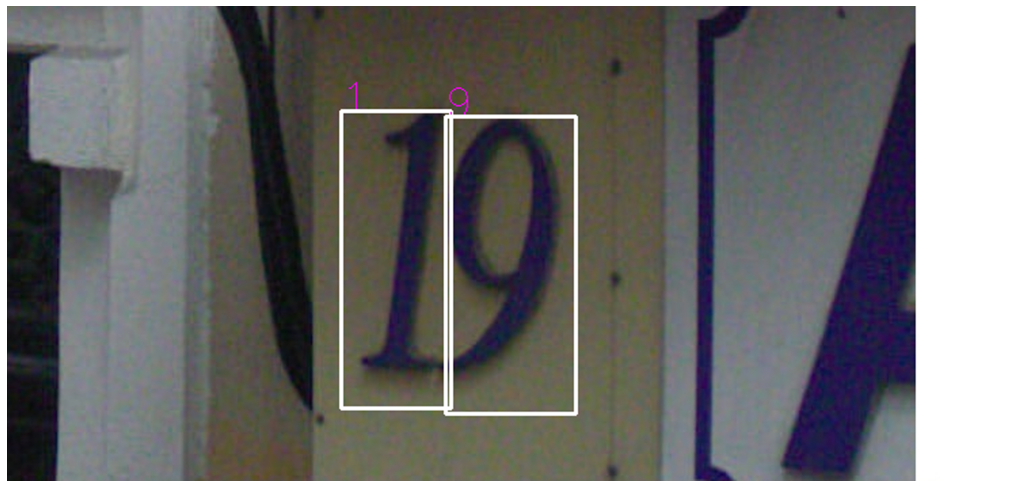

In [5]:
#Print image example and show information of the json files
import cv2
import matplotlib.pyplot as plt

item = dataList[0]

print(item)

image = cv2.imread(item['filename'])

for box in item['boxes']:
  print(box)
  
  left = int(box['left'])
  top = int(box['top'])
  right = int(box['left'] + box['width'])
  bottom = int(box['top'] + box['height'])
  
  label = int(box['label'])
  
  #Change "10" labels to "0"
  if label == 10:
    label = 0

  cv2.putText(image,str(label),  (left, top), cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 0, 255), 1)
  cv2.rectangle(image, (left, top), (right, bottom), (255, 255, 255), 2)
  
imShowCv(image)

Original shape of the image:
(350, 741)
Original shape of the first digit:
(219, 81)
Modified shape of the first digit:
(25, 10)
Digit label:
1.0


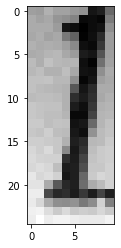

In [6]:
#Show shapes of image, digit and modified digit
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

img = dataList[0]

img_array= cv2.imread(img['filename'], cv2.IMREAD_GRAYSCALE) #Read the image and convert it into grayscale
print('Original shape of the image:')
print(img_array.shape)
first= img_array[77:(77+219), 246:(246+81)] #Cut the first digit of the image
print('Original shape of the first digit:')
print(first.shape)
new_array= cv2.resize(first, (10, 25)) #Resize the digit to have height=25 and width=10
print('Modified shape of the first digit:')
print(new_array.shape)
print('Digit label:')
print(img['boxes'][0]['label'])
plt.imshow(new_array, cmap="gray")
plt.show()

In [7]:
#Get train and test data ready to be feeded to the model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.utils import to_categorical

#Dimensions
img_h=25
img_w=10

X_train= []
y_train= []
for img in dataList:
  img_array= cv2.imread(img['filename'], cv2.IMREAD_GRAYSCALE) #Read the image and convert it into grayscale
  for digit in img['boxes']:
    item= img_array[int(digit['top']):int(digit['top'] + digit['height']), int(digit['left']):int(digit['left'] + digit['width'])] #Cut the digit
    if item.shape[0] < img_h or item.shape[1] < img_w: #Ignore digits that are smaller than the dimensions
      pass
    else:
      new_item= cv2.resize(item, (img_w, img_h))
      X_train.append(new_item)
      if int(digit['label']) == 10:
        y_train.append(0)
      else:
        y_train.append(int(digit['label']))

X_train= np.array(X_train).reshape(-1, img_h, img_w, 1)
X_train = X_train.astype('float32')
X_train= X_train/255.0 #Normalize the data
y_train= np.array(y_train)
y_train= to_categorical(y_train)
print("Number of train instances:")
print(len(y_train))
print("X_train shape:")
print(X_train.shape)
print("y_train shape:")
print(y_train.shape)

X_test= []
y_test= []
for img in dataTest:
  img_array= cv2.imread(img['filename'], cv2.IMREAD_GRAYSCALE) #Read the image and convert it into grayscale
  for digit in img['boxes']:
    item= img_array[int(digit['top']):int(digit['top'] + digit['height']), int(digit['left']):int(digit['left'] + digit['width'])] #Cut the digit
    if item.shape[0] < img_h or item.shape[1] < img_w: #Ignore digits that are smaller than the dimensions
      pass
    else:
      new_item= cv2.resize(item, (img_w, img_h))
      X_test.append(new_item)
      if int(digit['label']) == 10:
        y_test.append(0)
      else:
        y_test.append(int(digit['label']))

X_test= np.array(X_test).reshape(-1, img_h, img_w, 1)
X_test = X_test.astype('float32')
X_test= X_test/255.0 #Normalize the data
y_test= np.array(y_test)
y_test= to_categorical(y_test)
print("Number of test instances:")
print(len(y_test))
print("X_test shape:")
print(X_test.shape)
print("y_test shape:")
print(y_test.shape)

Using TensorFlow backend.


Number of train instances:
452017
X_train shape:
(452017, 25, 10, 1)
y_train shape:
(452017, 10)
Number of test instances:
12391
X_test shape:
(12391, 25, 10, 1)
y_test shape:
(12391, 10)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 8, 32)         320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 23, 8, 32)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 23, 8, 32)         128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 8, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 6, 64)         18496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 21, 6, 64)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 21, 6, 64)        

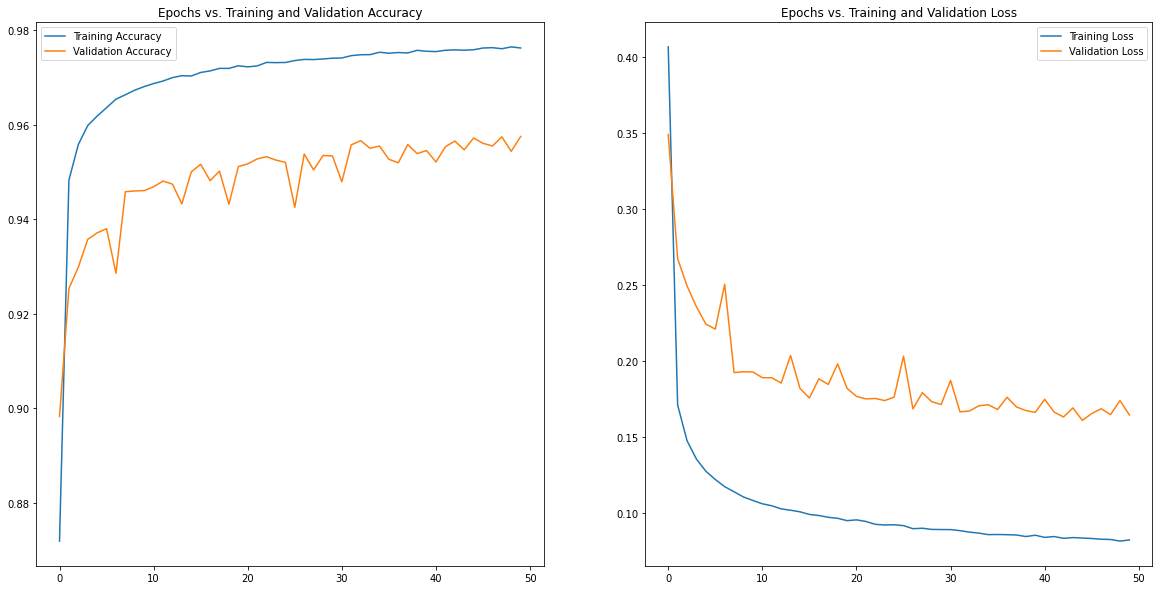

/content
12391/12391 [==============================] - 3s 212us/step
loss 0.16101696088019593
 accuracy  0.9572269916534424


In [0]:
#All the training part
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import output
from keras.preprocessing.image import ImageDataGenerator

#Data augmentation
datagen = ImageDataGenerator(rotation_range=8, zoom_range=[0.95, 1.05], height_shift_range=0.10, shear_range=0.15)

#Model
model= models.Sequential()
model.add(layers.Conv2D(32, (3,3), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(layers.LeakyReLU(alpha=0.01)) #Activation function
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3)))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(64, (3,3)))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, (4,4)))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.LeakyReLU(alpha=0.01))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10,activation ='softmax'))

optimizer = optimizers.Adam(lr=1e-3)

model.compile(optimizer= 'adam', 
		loss ='categorical_crossentropy',
		metrics = ['accuracy'])

model.summary()

early_stopping = callbacks.EarlyStopping(patience=10, min_delta=1e-4)
model_checkpoint = callbacks.ModelCheckpoint('best.h5', save_best_only=True)

%cd drive/'My Drive'/SVHN/model/

#history= model.fit(X_train, y_train, epochs = 50, validation_data=(X_test, y_test), batch_size=254, callbacks=[early_stopping, model_checkpoint]) #Train WITHOUT data augmentation
history= model.fit(datagen.flow(X_train, y_train, batch_size=254), epochs = 50, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint]) #Train with data augmentation

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

model= models.load_model('best.h5')

%cd /content

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("loss", test_loss)
print(" accuracy ", test_accuracy)
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()') #Beeps when training ends

In [0]:
a=0
'''
a = []
while(1):
  a.append('1')
'''

"\na = []\nwhile(1):\n  a.append('1')\n"

In [21]:
#Demo RESULTS
from keras import models

%cd drive/'My Drive'/SVHN/95_72/

#Load best model
model= models.load_model('best.h5')

%cd /content

model.summary()

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("loss", test_loss)
print(" accuracy ", test_accuracy)

/content/drive/My Drive/SVHN/95_72
/content
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 23, 8, 32)         320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 23, 8, 32)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 23, 8, 32)         128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 8, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 6, 64)         18496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 21, 6, 64)         0         
_________________________________________________________________
batch_norm

Actual labels:
[2 0 5]
Predicted labels:
[2 0 5]


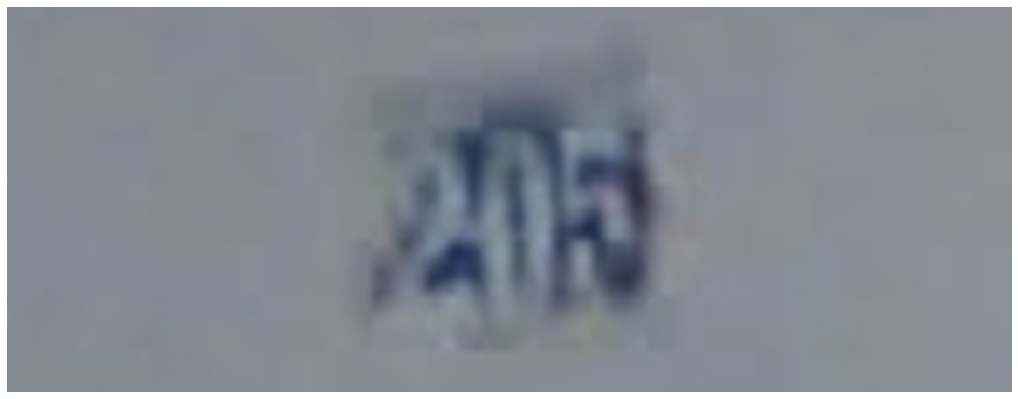

In [31]:
#Predict random image from dataTest

import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from keras import models
import random
%matplotlib inline

def imShowCv(image):

  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

img_h=25
img_w=10

cont= 0
while cont == 0:
  X= []
  y= []
  rand= random.randint(1, len(dataTest) + 1)
  img = dataTest[rand]
  img_array= cv2.imread(img['filename'], cv2.IMREAD_GRAYSCALE)

  for digit in img['boxes']:
    item= img_array[int(digit['top']):int(digit['top'] + digit['height']), int(digit['left']):int(digit['left'] + digit['width'])]
    if item.shape[0] < 25 or item.shape[1] < 10:
      cont= 0
      break
    else:
      cont+= 1
      new_item= cv2.resize(item, (img_w, img_h))
      X.append(new_item)
      if int(digit['label']) == 10:
        y.append(0)
      else:
        y.append(int(digit['label']))

image = cv2.imread(img['filename'])

imShowCv(image)

X_final_test= np.array(X).reshape(-1, img_h, img_w, 1)
X_final_test = X_final_test.astype('float32')
X_final_test= X_final_test/255.0

y= np.array(y)

predictions = model.predict(X_final_test)

classes = np.argmax(predictions, axis = 1)

print('Actual labels:')
print(y)
print('Predicted labels:')
print(classes)